<a href="https://colab.research.google.com/github/Jeromeschmidt/LendingClubLoanData/blob/main/LendingClubLoanData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lending Club Loan Data Analysis and Modeling

### Notes and Assumptions:

- Goal: Classify different loans into grades based on included features.

- Due to Google Colab resource limits the following assumptions were made
  - Due to long training times, I made the assumption that we do not need to interpret feature importance.
  - Looking to classify high grade (A,B,C) vs low grade loans (D,E,F,G) instead of each individual grade for ML methods.
  - Predict specific grade(A,B,C,...) for Neural Networks method.

- Next Improvements:
  - Implement TFX pipeline
  - Improve Feature Engineering for ML data

#### *Update Notes:*

- Added Deep Neural Network with Keras.
- Keras model predicts specific grade(A,B,C,...) instead of high grade vs. low grade. To do this with ML methods drastically increased training time.
- Created seperate feature engineering process for Deep Learning model to optimize performance. Added One-hot encoding for non-ordinal variables
- Kept similiar feature engineering process for Machine Learning methods to keep training time low.

In [1]:
"""
Import statements taken from https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb
"""

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

!pip3 install xgboost

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import Data from Google Drive

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load CSV from Google Drive
df=pd.read_csv('drive/MyDrive/Datasets/Loan_Data/accepted_2007_to_2018Q4.csv.gz')

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,10+ years,MORTGAGE,63000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,10+ years,MORTGAGE,110000.0,Source Verified,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,3 years,MORTGAGE,104433.0,Source Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [5]:
df['loan_amnt'].isna().value_counts()

False    2260668
True          33
Name: loan_amnt, dtype: int64

In [6]:
df['loan_amnt'].dtype

dtype('float64')

In [7]:
# Get Number of entries in Dataset
len(df)

2260701

In [8]:
# Get column types
df.dtypes

id                        object
member_id                float64
loan_amnt                float64
funded_amnt              float64
funded_amnt_inv          float64
                          ...   
settlement_status         object
settlement_date           object
settlement_amount        float64
settlement_percentage    float64
settlement_term          float64
Length: 151, dtype: object

In [9]:
# Get ratio of NaN values to number of entries
(df.isna().sum()/len(df)).to_dict()

{'acc_now_delinq': 2.7425121676860406e-05,
 'acc_open_past_24mths': 0.022144901072720363,
 'addr_state': 1.4597242182845055e-05,
 'all_util': 0.3832355539277419,
 'annual_inc': 1.636660487167476e-05,
 'annual_inc_joint': 0.9466050574578416,
 'application_type': 1.4597242182845055e-05,
 'avg_cur_bal': 0.031131494169286428,
 'bc_open_to_buy': 0.03316139551404631,
 'bc_util': 0.033663894517673945,
 'chargeoff_within_12_mths': 7.873663965292182e-05,
 'collection_recovery_fee': 1.4597242182845055e-05,
 'collections_12_mths_ex_med': 7.873663965292182e-05,
 'debt_settlement_flag': 1.4597242182845055e-05,
 'debt_settlement_flag_date': 0.9848516013395845,
 'deferral_term': 0.9951709668815115,
 'delinq_2yrs': 2.7425121676860406e-05,
 'delinq_amnt': 2.7425121676860406e-05,
 'desc': 0.9442354384768264,
 'disbursement_method': 1.4597242182845055e-05,
 'dti': 0.0007714421323297508,
 'dti_joint': 0.9466068268205304,
 'earliest_cr_line': 2.7425121676860406e-05,
 'emp_length': 0.06499753837415917,
 'em

## Deal with NaN values

In [10]:
# Gets columns that have high percentage of NaN values. Currently set to 0.3 to keep as many columns of possible.
columns_to_drop = list()
for key, value in (df.isna().sum()/len(df)).to_dict().items():
  if value >= 0.3:
    columns_to_drop.append(key)

columns_to_drop

['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_

In [11]:
df = df.drop(columns_to_drop, axis=1)

In [12]:
# Drop Unnecessary Columns
unneeded_columns = ['id','emp_title', 'url', 'title']

df = df.drop(unneeded_columns, axis=1)

In [13]:
len(df)

2260701

In [14]:
# Drops remaining rows with NaN values while still retaining significant amount of entries
df = df.dropna()

In [15]:
len(df)

1683228

In [16]:
# Shows new ratio of NaN entries to size of dataframe
(df.isna().sum()/len(df)).to_dict()

{'acc_now_delinq': 0.0,
 'acc_open_past_24mths': 0.0,
 'addr_state': 0.0,
 'annual_inc': 0.0,
 'application_type': 0.0,
 'avg_cur_bal': 0.0,
 'bc_open_to_buy': 0.0,
 'bc_util': 0.0,
 'chargeoff_within_12_mths': 0.0,
 'collection_recovery_fee': 0.0,
 'collections_12_mths_ex_med': 0.0,
 'debt_settlement_flag': 0.0,
 'delinq_2yrs': 0.0,
 'delinq_amnt': 0.0,
 'disbursement_method': 0.0,
 'dti': 0.0,
 'earliest_cr_line': 0.0,
 'emp_length': 0.0,
 'fico_range_high': 0.0,
 'fico_range_low': 0.0,
 'funded_amnt': 0.0,
 'funded_amnt_inv': 0.0,
 'grade': 0.0,
 'hardship_flag': 0.0,
 'home_ownership': 0.0,
 'initial_list_status': 0.0,
 'inq_last_6mths': 0.0,
 'installment': 0.0,
 'int_rate': 0.0,
 'issue_d': 0.0,
 'last_credit_pull_d': 0.0,
 'last_fico_range_high': 0.0,
 'last_fico_range_low': 0.0,
 'last_pymnt_amnt': 0.0,
 'last_pymnt_d': 0.0,
 'loan_amnt': 0.0,
 'loan_status': 0.0,
 'mo_sin_old_il_acct': 0.0,
 'mo_sin_old_rev_tl_op': 0.0,
 'mo_sin_rcnt_rev_tl_op': 0.0,
 'mo_sin_rcnt_tl': 0.0,
 '

## Exploratory Data Analysis

In [17]:
df['grade'].value_counts()

C    493587
B    488347
A    310141
D    245355
E    103608
F     32529
G      9661
Name: grade, dtype: int64

In [18]:
df['grade'].value_counts(normalize=True)

C    0.293238
B    0.290125
A    0.184254
D    0.145765
E    0.061553
F    0.019325
G    0.005740
Name: grade, dtype: float64

### Income vs. Loan Amount

In [19]:
# Get mean income for each grade
grade_income_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['annual_inc'][df['grade'] == val].mean()))
  grade_income_dict[val] = df['annual_inc'][df['grade'] == val].mean()

A: 95306.74629926392
B: 82568.11875746145
C: 77719.55360850263
D: 74386.19673024789
E: 74542.23926115736
F: 74387.39250853089
G: 76534.94582134356


<BarContainer object of 7 artists>

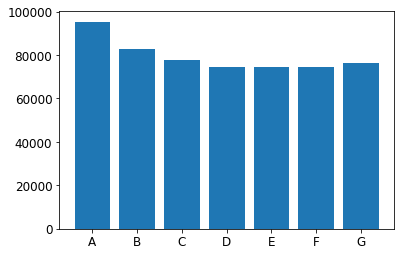

In [20]:
plt.bar(grade_income_dict.keys(), grade_income_dict.values())

In [21]:
# Get mean loan amount for each grade
grade_loanAmt_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['loan_amnt'][df['grade'] == val].mean()))
  grade_loanAmt_dict[val] = df['loan_amnt'][df['grade'] == val].mean()

A: 15034.540015670293
B: 14448.22559573418
C: 15358.801487883595
D: 16133.935827678262
E: 17923.551752760406
F: 19506.7047864982
G: 20809.696201221406


<BarContainer object of 7 artists>

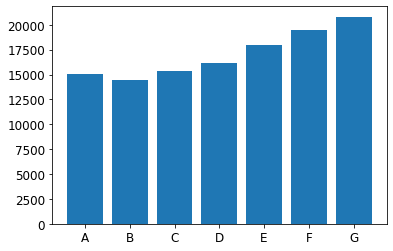

In [22]:
plt.bar(grade_loanAmt_dict.keys(), grade_loanAmt_dict.values())

In [23]:
income_loanAmt_dict = dict()
for key, value in grade_income_dict.items():
  print("{}: {}".format(key, grade_loanAmt_dict[key]/grade_income_dict[key]))
  income_loanAmt_dict[key] = grade_loanAmt_dict[key]/grade_income_dict[key]

A: 0.15774895901347552
B: 0.1749855248388899
C: 0.19761824116039856
D: 0.21689421608939002
E: 0.24044826034760738
F: 0.2622313288405846
G: 0.2718979673651005


<BarContainer object of 7 artists>

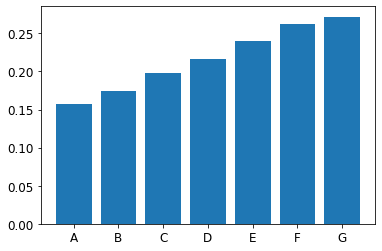

In [24]:
plt.bar(income_loanAmt_dict.keys(), income_loanAmt_dict.values())

Generally, higher graded loan requests have have incomes and lower amounts requested. Loans with A grade typically request loans that are ~15% of their income and G graded loans are typically ~27% of the requesters income.

### Loan Amount vs Funding Amount

In [25]:
# Get mean funded percentage for each grade
grade_fundPct_dict = dict()

for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['funded_amnt'][df['grade'] == val].sum() / df['loan_amnt'][df['grade'] == val].sum()))
  grade_fundPct_dict[val] = df['funded_amnt'][df['grade'] == val].sum() / df['loan_amnt'][df['grade'] == val].sum()

A: 0.9999970296991111
B: 1.0
C: 0.9999987336603853
D: 0.9999999747381727
E: 1.0
F: 0.9999849889745791
G: 0.9999995025926736


<BarContainer object of 7 artists>

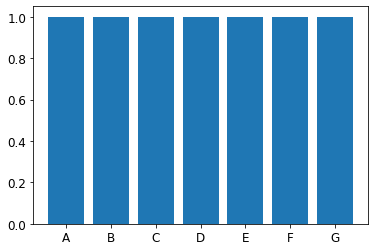

In [26]:
plt.bar(grade_fundPct_dict.keys(), grade_fundPct_dict.values())

Funding Amount is always very close to the requested loan amount

### Visualaize Boxplots for loan amounts for each grade

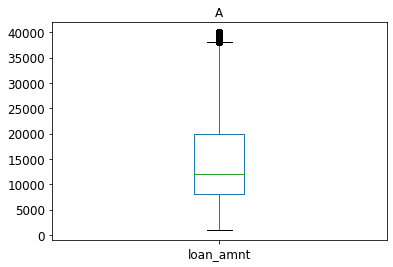

In [27]:
df['loan_amnt'][df['grade'] == 'A'].plot.box(title='A')

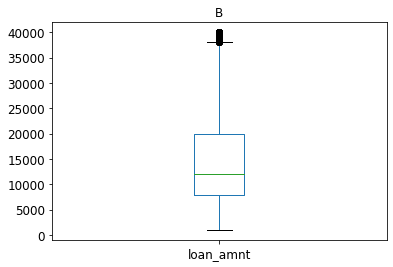

In [28]:
df['loan_amnt'][df['grade'] == 'B'].plot.box(title='B')

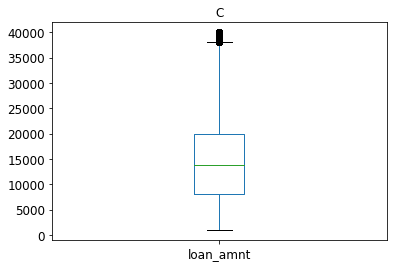

In [29]:
df['loan_amnt'][df['grade'] == 'C'].plot.box(title='C')

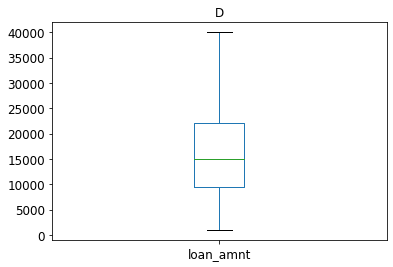

In [30]:
df['loan_amnt'][df['grade'] == 'D'].plot.box(title='D')

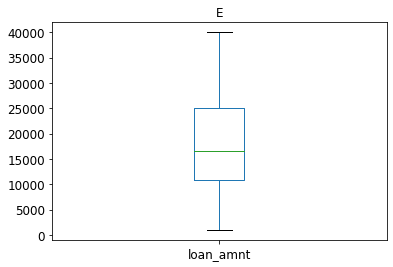

In [31]:
df['loan_amnt'][df['grade'] == 'E'].plot.box(title='E')

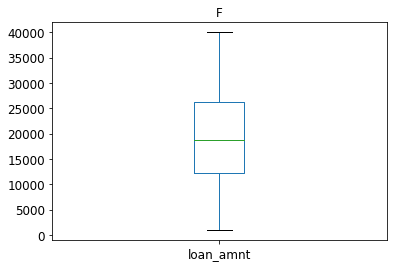

In [32]:
df['loan_amnt'][df['grade'] == 'F'].plot.box(title='F')

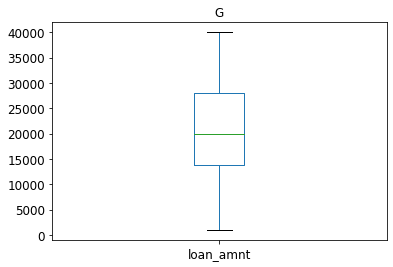

In [33]:
df['loan_amnt'][df['grade'] == 'G'].plot.box(title='G')

### Fico Scores vs. Loan Grade

In [34]:
# Get mean low fico for each grade
grade_ficoLow_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['fico_range_low'][df['grade'] == val].mean()))
  grade_ficoLow_dict[val] = df['fico_range_low'][df['grade'] == val].mean()

A: 727.687664642856
B: 699.4563701630193
C: 689.1246021471392
D: 683.8617513398952
E: 682.3541135819628
F: 680.514925143718
G: 679.5140254632025


<BarContainer object of 7 artists>

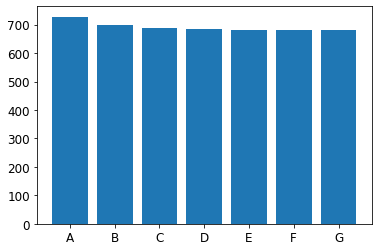

In [35]:
plt.bar(grade_ficoLow_dict.keys(), grade_ficoLow_dict.values())

In [36]:
# Get mean high fico for each grade
grade_ficoHigh_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['fico_range_high'][df['grade'] == val].mean()))
  grade_ficoHigh_dict[val] = df['fico_range_high'][df['grade'] == val].mean()

A: 731.6881224991214
B: 703.4564582151626
C: 693.1246183550215
D: 687.8617513398952
E: 686.3541135819628
F: 684.5149558855176
G: 683.5140254632025


<BarContainer object of 7 artists>

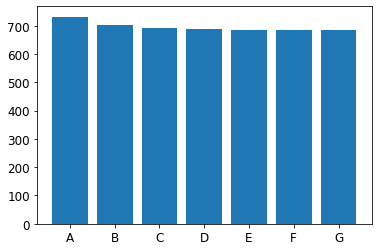

In [37]:
plt.bar(grade_ficoHigh_dict.keys(), grade_ficoHigh_dict.values())

Loans with higher grades trend with higher FICO scores.

### Grade vs. Interest Rate

In [38]:
# Get mean interest rate for each grade
grade_intRate_dict = dict()
for val in sorted(df['grade'].unique()):
  print("{}: {}".format(val, df['int_rate'][df['grade'] == val].mean()))
  grade_intRate_dict[val] = df['int_rate'][df['grade'] == val].mean()

A: 7.093674844667953
B: 10.665618750646548
C: 14.155488981718358
D: 18.18333797970362
E: 21.898725001930746
F: 25.633180854000802
G: 28.39819790911862


<BarContainer object of 7 artists>

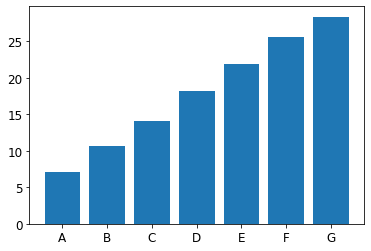

In [39]:
plt.bar(grade_intRate_dict.keys(), grade_intRate_dict.values())

This graph shows the average interest rate for each loan grade.

## General Feature Engineering

### Modify Date Columns

#### Split Date columns into Date and Month

In [40]:
# Alter date columns
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

In [41]:
for column in date_columns:
    df[column + '_month'] = df[column].apply(lambda x: x[0:3])
    df[column + '_year'] = df[column].apply(lambda x: x[-4:])

In [42]:
df = df.drop(date_columns, axis=1)

In [43]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190xx,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,Dec,2015,Aug,2003,Jan,2019,Mar,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577xx,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,Dec,2015,Dec,1999,Jun,2016,Mar,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605xx,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,Dec,2015,Aug,2000,Jun,2017,Mar,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174xx,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,Dec,2015,Jun,1998,Jul,2016,Mar,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10+ years,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550xx,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,Dec,2015,Jun,1990,Nov,2016,Mar,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4 years,OWN,125000.0,Not Verified,Current,n,credit_card,967xx,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,

#### Encode Months by Month Order

In [44]:
month_ordering = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for column in date_columns:
    df[column + '_month'] = df[column + '_month'].apply(lambda x: month_ordering.index(x))

In [45]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10+ years,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190xx,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10+ years,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577xx,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10+ years,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605xx,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3 years,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174xx,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10+ years,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550xx,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4 years,OWN,125000.0,Not Verified,Current,n,credit_card,967xx,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,f,13951.43,13951.43,149

### Encode Employment Length

In [46]:
# Encode emp_length

emp_ordering = [
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years'
]

df['emp_length'] = df['emp_length'].apply(lambda x: emp_ordering.index(x))

In [47]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190xx,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577xx,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605xx,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174xx,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550xx,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4,OWN,125000.0,Not Verified,Current,n,credit_card,967xx,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,f,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00

### Encode Loan Term Length

In [48]:
# df['term'] = df['term'].apply(lambda x: x[1:3]).astype('float64')

In [49]:
# df

### Encode Zip Code

In [50]:
df['zip_code'] = df['zip_code'].apply(lambda x: x[:3]).astype('float64')

In [51]:
df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190.0,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577.0,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605.0,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174.0,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550.0,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4,OWN,125000.0,Not Verified,Current,n,credit_card,967.0,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,f,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00

## Machine Learning Feature Engineering

In [52]:
ml_df = df.copy()

In [53]:
ml_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190.0,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577.0,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605.0,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174.0,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550.0,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4,OWN,125000.0,Not Verified,Current,n,credit_card,967.0,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,f,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00

In [54]:
# Shows column types
ml_df.dtypes.to_list()

[dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dty

### Scale Numerical Data

In [55]:
# Gets all columns with type 'float64'
columns_to_scale = list()

columns_to_scale = list(ml_df.select_dtypes(include=['float64']).columns)

columns_to_scale

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'annual_inc',
 'zip_code',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

ml_df[columns_to_scale] = scaler.fit_transform(ml_df[columns_to_scale])

In [57]:
ml_df['grade'] = np.where(  (ml_df['grade'] == 'A') | (ml_df['grade'] == 'B')  |  (ml_df['grade'] == 'C'), 1, 0)

In [58]:
ml_df['grade'].value_counts()

1    1292075
0     391153
Name: grade, dtype: int64

In [59]:
# Shows column types
ml_df.dtypes.to_list()

[dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('int64'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('O'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),


Encode Categorical Data

In [60]:
# Gets all columns with type 'object'
columns_to_encode = list()

columns_to_encode = list(ml_df.select_dtypes(include=['object']).columns)

columns_to_encode

['term',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method',
 'debt_settlement_flag',
 'issue_d_year',
 'earliest_cr_line_year',
 'last_pymnt_d_year',
 'last_credit_pull_d_year']

In [61]:
# Casts columns of type 'object' to type 'str' to label encode
ml_df[columns_to_encode] = ml_df[columns_to_encode].astype('str')

In [62]:
# Encodes all columns that were previously type 'object'
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
ml_df[columns_to_encode] = ml_df[columns_to_encode].apply(encoder.fit_transform)

In [63]:
ml_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,-1.278930,-1.278929,-1.278660,0,0.160512,-1.238610,1,13,10,1,-0.230659,0,3,0,2,-1.035628,38,-1.117578,-0.360095,-0.705835,-0.705827,0.449711,-0.910240,-0.347755,-0.627380,-0.819035,-1.020710,1,-0.576314,-0.576261,-0.794896,-0.794726,-0.726767,-0.614721,-0.128384,-0.196787,-0.188725,-0.565777,-1.696524,-1.047439,...,0.421461,-0.522666,-0.627237,-0.612314,-0.323110,-0.642506,-0.515515,1.033205,-0.753769,-0.504570,-0.967982,-0.615491,-0.811607,-0.951221,-0.661610,-0.509057,-0.906175,-0.023723,-0.050775,-0.165538,0.418268,-1.954852,-1.154903,-0.354067,-0.126309,-0.062007,-0.915533,-0.919672,-0.738127,0,0,0,11,3,7,61,0,7,2,7
1,1.004647,1.004650,1.005448,0,-0.250594,1.355550,1,10,10,1,-0.143991,0,3,0,11,0.217408,41,-0.256252,0.783926,0.531274,0.531262,3.914062,1.722317,-0.347755,0.217968,-1.252614,1.052169,1,-0.576314,-0.576261,1.321628,1.322588,1.767931,-0.557058,-0.128384,-0.196787,-0.188725,-0.436853,0.169358,0.183534,...,-0.237225,0.172385,-0.691688,-0.757623,1.233770,-0.709244,-1.186449,-0.384285,0.567418,-0.199992,2.837887,1.928989,-0.411671,2.432710,1.569177,-0.205300,1.728043,-0.023723,-0.050775,-0.165538,-0.125004,0.363819,-0.940038,-0.354067,-0.126309,0.677549,-0.299145,2.416562,-0.501677,0,0,0,11,3,11,57,5,4,2,7
2,0.495983,0.495985,0.496666,1,-0.499314,-0.086613,1,8,10,1,-0.161324,0,3,0,4,0.308067,14,-0.704311,-0.360095,-0.087280,-0.087282,-0.705072,-1.085744,-0.347755,-0.396711,0.275237,-0.606134,1,-0.576314,-0.576261,1.025551,1.026400,1.212240,0.073184,-0.128384,-0.196787,-0.188725,1.951262,0.238465,0.229126,...,-0.011390,0.085503,0.081721,0.986085,1.752729,2.594292,0.490885,-0.384285,-0.753769,-0.809149,-0.967982,-0.827532,-0.411671,-0.951221,-0.909475,-0.812813,-1.081790,-0.023723,-0.050775,-0.165538,-1.211546,0.657894,0.240327,-0.354067,-0.126309,0.157564,-0.702811,-0.754813,-0.713407,0,0,0,11,3,7,58,5,5,2,7
4,-0.542991,-0.542989,-0.542549,1,1.899493,-0.617723,0,25,3,1,0.197767,1,3,0,6,-1.087433,38,0.533791,0.783926,-0.087280,-0.087282,2.759278,-0.032721,-0.347755,0.238712,0.617971,0.803424,1,-0.576314,-0.576261,-0.066210,-0.065767,0.077211,-0.425319,-0.128384,-0.196787,-0.188725,1.039399,0.238465,0.229126,...,0.045069,0.367868,-0.562786,-0.467005,2.271689,-0.642506,-1.018715,-0.384285,0.127022,0.104586,0.069982,0.232669,0.121577,-0.316734,0.577716,0.098456,-0.028102,-0.023723,-0.050775,-0.165538,0.961539,0.273334,0.519373,-0.354067,-0.126309,1.360460,0.794439,-0.143097,0.870131,0,0,0,11,3,5,56,6,4,2,6
6,0.495983,0.495985,0.496666,0,-0.830254,0.675804,1,6,10,1,0.852690,0,3,0,2,0.129987,23,-0.374207,-0.360095,-0.551196,-0.551191,-0.705072,-0.032721,-0.347755,3.194381,1.443836,0.140102,0,-0.576314,-0.576261,0.894911,0.895712,1.212240,-0.405859,-0.128384,-0.196787,-0.188725,1.930047,-0.452603,-0.226790,...,0.308544,1.410445,-0.176082,

### Seperate Features and Target Columns

In [64]:
features_ml = ml_df.drop(['grade', 'sub_grade'], axis=1)

target_ml = ml_df['grade']

### Scale Features

In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_ml = scaler.fit_transform(features_ml)

## Deep Learning Feature Engineering

In [66]:
dl_df = df.copy()

In [67]:
dl_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,Fully Paid,n,debt_consolidation,190.0,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,n,small_business,577.0,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,10,MORTGAGE,63000.0,Not Verified,Fully Paid,n,home_improvement,605.0,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,Fully Paid,n,major_purchase,174.0,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,36 months,9.17,637.58,B,B2,10,MORTGAGE,180000.0,Not Verified,Fully Paid,n,debt_consolidation,550.0,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,f,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,N,Cash,N,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,4,OWN,125000.0,Not Verified,Current,n,credit_card,967.0,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,f,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00

### Encode Binary Categories

In [68]:
bin_columns = list()

for column in dl_df.columns:
  if dl_df[column].unique == 2:
    bin_columns.append(column)

bin_columns

[]

In [69]:
binary_features = ['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
binary_positives = [' 60 months', 'y', 'w', 'Individual', 'Y', 'Cash', 'Y']

def binary_encode(df, column, positive_value):
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)

for feature, positive_value in zip(binary_features, binary_positives):
    binary_encode(dl_df, feature, positive_value)

In [70]:
dl_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,...,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag,issue_d_month,issue_d_year,earliest_cr_line_month,earliest_cr_line_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year
0,3600.0,3600.0,3600.0,0,13.99,123.03,C,C4,10,MORTGAGE,55000.0,Not Verified,Fully Paid,0,debt_consolidation,190.0,PA,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,...,148.0,128.0,3.0,3.0,1.0,4.0,4.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,0,1,0,11,2015,7,2003,0,2019,2,2019
1,24700.0,24700.0,24700.0,0,11.99,820.28,C,C1,10,MORTGAGE,65000.0,Not Verified,Fully Paid,0,small_business,577.0,SD,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,1,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,...,113.0,192.0,2.0,2.0,4.0,2.0,0.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,0,1,0,11,2015,11,1999,5,2016,2,2019
2,20000.0,20000.0,20000.0,1,10.78,432.66,B,B4,10,MORTGAGE,63000.0,Not Verified,Fully Paid,0,home_improvement,605.0,IL,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,1,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,...,125.0,184.0,14.0,14.0,5.0,101.0,10.0,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,0,1,0,11,2015,7,2000,5,2017,2,2019
4,10400.0,10400.0,10400.0,1,22.45,289.91,F,F1,3,MORTGAGE,104433.0,Source Verified,Fully Paid,0,major_purchase,174.0,PA,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,...,128.0,210.0,4.0,4.0,6.0,4.0,1.0,0.0,4.0,6.0,5.0,9.0,10.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,96.6,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,0,1,0,11,2015,5,1998,6,2016,2,2018
6,20000.0,20000.0,20000.0,0,9.17,637.58,B,B2,10,MORTGAGE,180000.0,Not Verified,Fully Paid,0,debt_consolidation,550.0,MN,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,0,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,...,142.0,306.0,10.0,10.0,4.0,12.0,10.0,0.0,4.0,6.0,4.0,5.0,7.0,9.0,16.0,6.0,12.0,0.0,0.0,0.0,2.0,96.3,100.0,0.0,0.0,388852.0,116762.0,31500.0,46452.0,0,1,0,11,2015,5,1990,10,2016,2,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,1,10.49,515.74,B,B3,4,OWN,125000.0,Not Verified,Current,0,credit_card,967.0,HI,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,0,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00,0.0,0.0,515.74,739.0,735.0,...,44.0,187.0,0.0,0.0,0.0,0.0,13.0

### One Hot Encode categories

In [71]:
# Get Columns to one hot encode
from sklearn.preprocessing import OneHotEncoder

one_hot_features = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

for column in one_hot_features:
  dummies = pd.get_dummies(dl_df[column])
  df_new = pd.concat([dl_df, dummies], axis=1)
  dl_df = df_new.drop(column, axis=1)

### Label Encode categories

In [72]:
dl_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,pymnt_plan,zip_code,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,...,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,3600.0,3600.0,3600.0,0,13.99,123.03,C,C4,10,55000.0,0,190.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,0.0,1.0,1,0.0,722.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,24700.0,0,11.99,820.28,C,C1,10,65000.0,0,577.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,1,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20000.0,20000.0,20000.0,1,10.78,432.66,B,B4,10,63000.0,0,605.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,1,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,0.0,1.0,0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10400.0,10400.0,10400.0,1,22.45,289.91,F,F1,3,104433.0,0,174.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,20000.0,20000.0,20000.0,0,9.17,637.58,B,B2,10,180000.0,0,550.0,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,0,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,1,10.49,515.74,B,B3,4,125000.0,0,967.0,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,0,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00,0.0,0.0,515.74,739.0,735.0,0.0,1.0,1,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260695,24000.0,24000.0,24000.0,1,10.49,515.74,B,B3,10,108000.0,0,840.0,34.94,0.0,695.0,699.0,1.0,24.0,1.0,21665.0,39.0,58.0,0,13951.42,13951.42,15008.530000,15008.53,10048.58,4959.95,0.00,0.0,0.0,515.74,734.0,730.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2260696,40000.0,40000.0,40000.0,1,10.49,859.56,B,B3,9,227000.0,0,907.0,12.75,7.0,705.0,709.0,1.0,5.0,0.0,8633.0,64.9,37.0,0,23252.59,23252.59,24903.930000,24903.93,16747.41,8156.52,0.00,0.0,0.0,859.56,724.0,720.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260697,24000.0,24000.0,24000.0,1,14.49,564.56,C,C4,6,110000.0,0,334.0,18.30,0.0,660.0,664.0,0.0,10.0,1.0,17641.0,68.1,31.0,0,0.00,0.00,6755.400000,6755.40,3521.91,3233.49,0.00,0.0,0.0,564.56,594.0,590.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

dl_df['grade'] = label_encoder.fit_transform(dl_df['grade'])

target_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
target_mappings

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}

In [74]:
dl_df

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,annual_inc,pymnt_plan,zip_code,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,...,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,3600.0,3600.0,3600.0,0,13.99,123.03,2,C4,10,55000.0,0,190.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,0.0,1.0,1,0.0,722.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,24700.0,0,11.99,820.28,2,C1,10,65000.0,0,577.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,1,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20000.0,20000.0,20000.0,1,10.78,432.66,1,B4,10,63000.0,0,605.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,1,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,0.0,1.0,0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10400.0,10400.0,10400.0,1,22.45,289.91,5,F1,3,104433.0,0,174.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,20000.0,20000.0,20000.0,0,9.17,637.58,1,B2,10,180000.0,0,550.0,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,0,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,1,10.49,515.74,1,B3,4,125000.0,0,967.0,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,0,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00,0.0,0.0,515.74,739.0,735.0,0.0,1.0,1,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260695,24000.0,24000.0,24000.0,1,10.49,515.74,1,B3,10,108000.0,0,840.0,34.94,0.0,695.0,699.0,1.0,24.0,1.0,21665.0,39.0,58.0,0,13951.42,13951.42,15008.530000,15008.53,10048.58,4959.95,0.00,0.0,0.0,515.74,734.0,730.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2260696,40000.0,40000.0,40000.0,1,10.49,859.56,1,B3,9,227000.0,0,907.0,12.75,7.0,705.0,709.0,1.0,5.0,0.0,8633.0,64.9,37.0,0,23252.59,23252.59,24903.930000,24903.93,16747.41,8156.52,0.00,0.0,0.0,859.56,724.0,720.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260697,24000.0,24000.0,24000.0,1,14.49,564.56,2,C4,6,110000.0,0,334.0,18.30,0.0,660.0,664.0,0.0,10.0,1.0,17641.0,68.1,31.0,0,0.00,0.00,6755.400000,6755.40,3521.91,3233.49,0.00,0.0,0.0,564.56,594.0,590.0,0.0,1.0,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Seperate Features and Target Columns

In [75]:
features_dl = dl_df.drop(['grade', 'sub_grade'], axis=1)

target_dl = dl_df['grade']

In [76]:
features_dl

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,pymnt_plan,zip_code,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,...,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,3600.0,3600.0,3600.0,0,13.99,123.03,10,55000.0,0,190.0,5.91,0.0,675.0,679.0,1.0,7.0,0.0,2765.0,29.7,13.0,1,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.00,0.0,0.0,122.67,564.0,560.0,0.0,1.0,1,0.0,722.0,144904.0,9300.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24700.0,24700.0,24700.0,0,11.99,820.28,10,65000.0,0,577.0,16.06,1.0,715.0,719.0,4.0,22.0,0.0,21470.0,19.2,38.0,1,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.00,0.0,0.0,926.35,699.0,695.0,0.0,1.0,1,0.0,0.0,204396.0,111800.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20000.0,20000.0,20000.0,1,10.78,432.66,10,63000.0,0,605.0,10.78,0.0,695.0,699.0,0.0,6.0,0.0,7869.0,56.2,18.0,1,0.00,0.00,22705.924294,22705.92,20000.00,2705.92,0.00,0.0,0.0,15813.30,704.0,700.0,0.0,1.0,0,0.0,0.0,189699.0,14000.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,10400.0,10400.0,10400.0,1,22.45,289.91,3,104433.0,0,174.0,25.37,1.0,695.0,699.0,3.0,12.0,0.0,21929.0,64.5,35.0,1,0.00,0.00,11740.500000,11740.50,10400.00,1340.50,0.00,0.0,0.0,10128.96,704.0,700.0,0.0,1.0,1,0.0,0.0,331730.0,34000.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,20000.0,20000.0,20000.0,0,9.17,637.58,10,180000.0,0,550.0,14.67,0.0,680.0,684.0,0.0,12.0,0.0,87329.0,84.5,27.0,0,0.00,0.00,21393.800000,21393.80,20000.00,1393.80,0.00,0.0,0.0,15681.05,654.0,650.0,0.0,1.0,1,0.0,0.0,360358.0,94200.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,24000.0,24000.0,24000.0,1,10.49,515.74,4,125000.0,0,967.0,10.98,0.0,725.0,729.0,0.0,15.0,2.0,22448.0,22.4,22.0,0,13951.43,13951.43,14977.430000,14977.43,10048.57,4928.86,0.00,0.0,0.0,515.74,739.0,735.0,0.0,1.0,1,0.0,0.0,31320.0,100300.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260695,24000.0,24000.0,24000.0,1,10.49,515.74,10,108000.0,0,840.0,34.94,0.0,695.0,699.0,1.0,24.0,1.0,21665.0,39.0,58.0,0,13951.42,13951.42,15008.530000,15008.53,10048.58,4959.95,0.00,0.0,0.0,515.74,734.0,730.0,0.0,1.0,1,0.0,0.0,140118.0,55600.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2260696,40000.0,40000.0,40000.0,1,10.49,859.56,9,227000.0,0,907.0,12.75,7.0,705.0,709.0,1.0,5.0,0.0,8633.0,64.9,37.0,0,23252.59,23252.59,24903.930000,24903.93,16747.41,8156.52,0.00,0.0,0.0,859.56,724.0,720.0,0.0,1.0,1,0.0,0.0,28398.0,13300.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2260697,24000.0,24000.0,24000.0,1,14.49,564.56,6,110000.0,0,334.0,18.30,0.0,660.0,664.0,0.0,10.0,1.0,17641.0,68.1,31.0,0,0.00,0.00,6755.400000,6755.40,3521.91,3233.49,0.00,0.0,0.0,564.56,594.0,590.0,0.0,1.0,1,0.0,0.0,62426.0,25900.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Scale Features

In [77]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features_dl = scaler.fit_transform(features_dl)

In [78]:
features_dl

array([[-1.27893035, -1.2789293 , -1.27866008, ..., -0.11925299,
        -0.06033872, -0.04667478],
       [ 1.00464673,  1.00464972,  1.00544799, ..., -0.11925299,
        -0.06033872, -0.04667478],
       [ 0.49598264,  0.4959852 ,  0.49666562, ..., -0.11925299,
        -0.06033872, -0.04667478],
       ...,
       [ 2.66051069,  2.66051507,  2.66169697, ..., -0.11925299,
        -0.06033872, -0.04667478],
       [ 0.92888825,  0.92889117,  0.92967189, ..., -0.11925299,
        -0.06033872, -0.04667478],
       [-0.15337577, -0.15337376, -0.15284378, ..., -0.11925299,
        -0.06033872, -0.04667478]])

In [79]:
target_dl

0          2
1          2
2          1
4          5
6          1
          ..
2260693    1
2260695    1
2260696    1
2260697    2
2260698    2
Name: grade, Length: 1683228, dtype: int64

## Seperate Features and Target Columns

In [80]:
features_ml = ml_df.drop(['grade', 'sub_grade'], axis=1)

target_ml = ml_df['grade']

## PCA

Note: PCA is primarily being done to reduce the compute time.

In [81]:
# Graphs Column correlations
corr = ml_df.corr()
corr.style.background_gradient()

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


In [82]:
# Test PCA with different amount of components to determine optimal number of components

from sklearn.decomposition import PCA

explained_variance_list = list()

for i in range(20):
  pca = PCA(n_components=i)

  temp_df = features_ml.copy()

  PCA_df = pca.fit_transform(temp_df)
  explained_variance_list.append(pca.explained_variance_ratio_.sum())
  print(pca.explained_variance_ratio_.sum())

0.0
0.5340635887405186
0.673832380992044
0.7100124662872023
0.741281898023572
0.7688827581661394
0.7956966043030895
0.8184889426021678
0.8344064721722619
0.8496243518854114
0.8632503967232424
0.8749372210366669
0.8850138080628093
0.8941292825912903
0.901260248823067
0.9077586828640644
0.9137703632043328
0.9192896916179637
0.923823776816453
0.9281410777469351


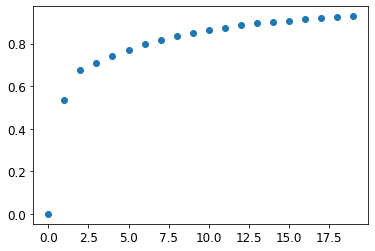

In [83]:
# Uses Elbow method to determine optional number of components
plt.scatter(x=[i for i in range(20)],y=explained_variance_list)

There's diminishing return after ~7 components so we'll use ~7 moving forward

In [84]:
# Makes PCA Dataframe that we will use to represent features

from sklearn.decomposition import PCA

pca = PCA(n_components=7)

temp_df = features_ml

features_PCA_df = pca.fit_transform(temp_df)

In [85]:
features_PCA_df

array([[ 14.68115513,  -3.43700437,   3.22756094, ...,   5.41054457,
         -2.4337553 ,  -4.01874076],
       [ 17.71920152,   2.2020762 ,   0.03031742, ...,   5.30347731,
         -5.62625295,   4.11101664],
       [ -9.28783055,   0.61893212,  -0.59256781, ...,   5.22549382,
         -2.18505719,  -2.07222256],
       ...,
       [-19.220203  ,   5.84864627,   3.71731689, ...,   3.73120971,
          4.23430706,  -0.85147181],
       [-14.30922972,   1.13488838,  -3.07854343, ...,   3.22516355,
         -0.37061924,   0.25565411],
       [ 19.74416635,   3.87925553,   3.05961769, ...,   3.67990686,
         -0.09605719,  -3.06974239]])

In [86]:
target_ml

0          1
1          1
2          1
4          0
6          1
          ..
2260693    1
2260695    1
2260696    1
2260697    1
2260698    1
Name: grade, Length: 1683228, dtype: int64

## Split data into training, validation, and testing

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_PCA_df, target_ml, test_size=0.15)

In [88]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)

## Build and Test Machine Learning Models

In [89]:
models = list()

### K Neighbors Classifier

In [90]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [91]:
knn.score(X_valid, y_valid)

0.7272504883819269

In [92]:
models.append(("knn", knn))

### Decision Tree

In [93]:
from sklearn import tree

decTree = tree.DecisionTreeClassifier()

decTree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [94]:
decTree.score(X_valid, y_valid)

0.6529395524709155

In [95]:
models.append(("decTree", decTree))

### SGD Classifier

In [96]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()

sgd.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [97]:
sgd.score(X_valid, y_valid)

0.7683304851668187

In [98]:
models.append(("sgd", sgd))

### XGBoost

In [99]:
import xgboost as xgb

xgbClas = xgb.XGBClassifier(n_jobs=-1)

xgbClas.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [100]:
xgbClas.score(X_valid, y_valid)

0.7683654319952192

In [101]:
models.append(("xgbClas", xgbClas))

### Random Forest Classifier

In [102]:
from sklearn.ensemble import RandomForestClassifier

RanForest = RandomForestClassifier(n_jobs=-1)

RanForest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [103]:
RanForest.score(X_valid, y_valid)

0.766866213056834

In [104]:
models.append(("RanForest", RanForest))

### MLP Classifier


In [105]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=300, early_stopping=True)

mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [106]:
mlp.score(X_valid, y_valid)

0.7683584426295391

In [107]:
models.append(("mlp", mlp))

### Compare model Metrics

In [108]:
# function to get necessary metrics
from sklearn.metrics import confusion_matrix


def get_metrics(confusion):
    acc = (confusion[0][0] + confusion[1][1])/(confusion[0][0] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    prec = (confusion[1][1])/(confusion[1][1] + confusion[1][0])
    
    recall = (confusion[1][1])/(confusion[1][1] + confusion[0][1])
    
    clas = (confusion[0][1] + confusion[1][0])/(confusion[0][1] + confusion[1][1] + confusion[0][1] + confusion[1][0])
    
    spec = (confusion[0][0])/(confusion[0][0] + confusion[0][1])
    
    f1 = 2*((prec*recall)/(prec+recall))
    
    print("acc: " + str(acc))
    print("prec: " + str(prec))
    print("recall: " + str(recall))
    print("clas: " + str(clas))
    print("spec: " + str(spec))
    print("f1: " + str(f1))
    return acc, prec, recall, clas, spec, f1

In [109]:
model_metrics = dict()
for model in models:
  print(model[0])
  y_pred = model[1].predict(X_valid)

  model_matrix = confusion_matrix(y_valid, y_pred)

  model_acc, model_prec, model_recall, model_clas, model_spec, model_f1 = get_metrics(model_matrix)

  model_metrics[model[0]] = dict()
  model_metrics[model[0]]["acc"] = model_acc
  model_metrics[model[0]]["prec"] = model_prec
  model_metrics[model[0]]["recall"] = model_recall
  model_metrics[model[0]]["clas"] = model_clas
  model_metrics[model[0]]["spec"] = model_spec
  model_metrics[model[0]]["f1"] = model_f1
  print("--------------------------")

knn
acc: 0.7272504883819269
prec: 0.912638669680747
recall: 0.7732475239893638
clas: 0.23122502125692887
spec: 0.11241175405780486
f1: 0.8371805810821806
--------------------------
decTree
acc: 0.6529395524709155
prec: 0.7642240183391932
recall: 0.77969688251181
clas: 0.31546830577659185
spec: 0.28386532311591145
f1: 0.771882917462002
--------------------------
sgd
acc: 0.7683304851668187
prec: 1.0
recall: 0.7683304851668187
clas: 0.18809389372973065
spec: 0.0
f1: 0.8689896957743584
--------------------------
xgbClas
acc: 0.7683654319952192
prec: 0.9997725794493694
recall: 0.7684511552620447
clas: 0.1881295750182362
spec: 0.0009050865866167863
f1: 0.8689809763271503
--------------------------
RanForest
acc: 0.766866213056834
prec: 0.991107856470342
recall: 0.7709033531688472
clas: 0.19094710749952057
spec: 0.02317021661738973
f1: 0.8672457538580937
--------------------------
mlp
acc: 0.7683584426295391
prec: 0.9999135801907604
recall: 0.7683876086584203
clas: 0.18810001504028243
spec: 

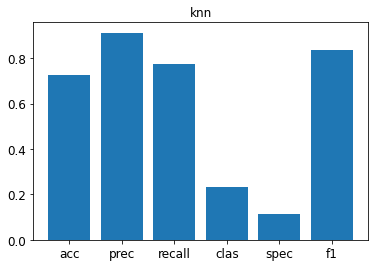

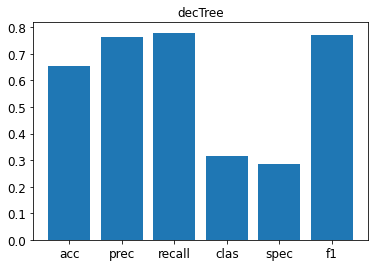

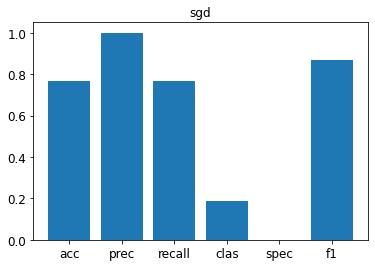

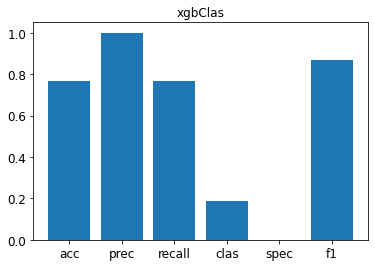

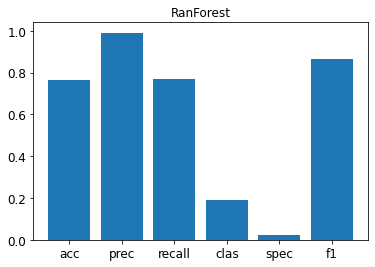

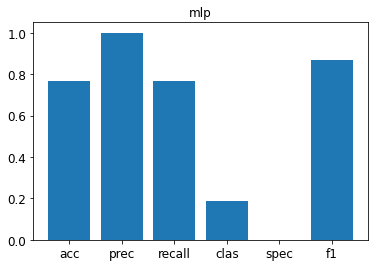

In [110]:
for key, value in model_metrics.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

### Grid Search on Random Forest Classifier
Causes Colab to crash but this is how I would do it.

In [111]:
# # https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
# from sklearn.model_selection import GridSearchCV

# n_estimators = [100, 300, 500, 800, 1200]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [2, 5, 10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10] 

# hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
#               min_samples_split = min_samples_split, 
#              min_samples_leaf = min_samples_leaf)

# gridF = GridSearchCV(RanForest, hyperF, cv = 3, verbose = 1)
# bestF = gridF.fit(X_train, y_train)

In [112]:
# bestF.score(X_valid, y_valid)

## Run Machine Learning Models on Testing Data

In [113]:
model_metrics = dict()

metric_model = dict()
metric_model["acc"] = dict()
metric_model["prec"] = dict()
metric_model["recall"] = dict()
metric_model["clas"] = dict()
metric_model["spec"] = dict()
metric_model["f1"] = dict()

for model in models:
  print(model[0])
  y_pred = model[1].predict(X_test)

  model_matrix = confusion_matrix(y_test, y_pred)

  model_acc, model_prec, model_recall, model_clas, model_spec, model_f1 = get_metrics(model_matrix)

  model_metrics[model[0]] = dict()
  model_metrics[model[0]]["acc"] = model_acc
  model_metrics[model[0]]["prec"] = model_prec
  model_metrics[model[0]]["recall"] = model_recall
  model_metrics[model[0]]["clas"] = model_clas
  model_metrics[model[0]]["spec"] = model_spec
  model_metrics[model[0]]["f1"] = model_f1


  metric_model["acc"][model[0]] = model_acc
  metric_model["prec"][model[0]] = model_prec
  metric_model["recall"][model[0]] = model_recall
  metric_model["clas"][model[0]] = model_clas
  metric_model["spec"][model[0]] = model_spec
  metric_model["f1"][model[0]] = model_f1
  print("--------------------------")

knn
acc: 0.7244905637958691
prec: 0.9125357039367471
recall: 0.7700600841877282
clas: 0.23298076858668204
spec: 0.1109253912779213
f1: 0.8352657553970464
--------------------------
decTree
acc: 0.6494445214567202
prec: 0.762713706172124
recall: 0.7755719487298213
clas: 0.31773895936990687
spec: 0.2798629049958635
f1: 0.7690890876266605
--------------------------
sgd
acc: 0.7654157672733034
prec: 1.0
recall: 0.7654157672733034
clas: 0.19001071495024285
spec: 0.0
f1: 0.8671223872158944
--------------------------
xgbClas
acc: 0.7655939956829119
prec: 0.9998188930744711
recall: 0.7656258667828981
clas: 0.1899638585927319
spec: 0.0013506896959259822
f1: 0.8671890778365715
--------------------------
RanForest
acc: 0.76415628651207
prec: 0.9909291302727987
recall: 0.7681720999450454
clas: 0.19280607685433424
spec: 0.024227996420672304
f1: 0.8654466244720971
--------------------------
mlp
acc: 0.7654276491672772
prec: 0.9999016848118558
recall: 0.765464815959183
clas: 0.19002791413995573
spec:

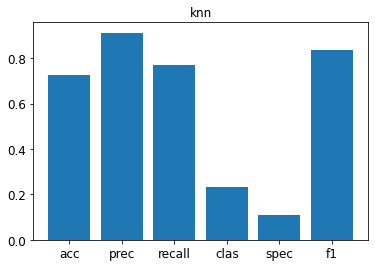

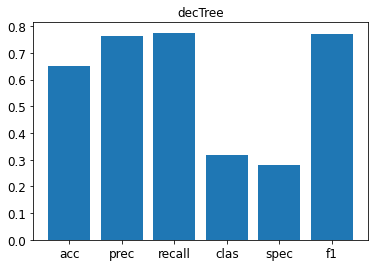

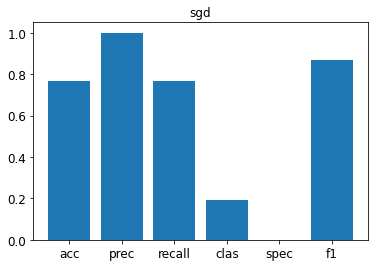

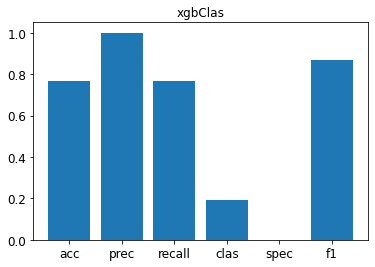

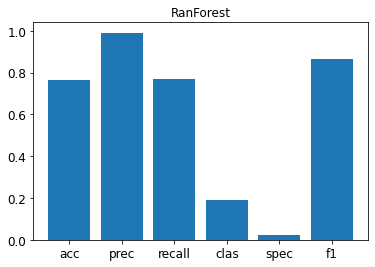

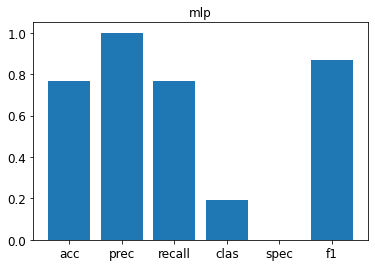

In [114]:
for key, value in model_metrics.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

In [115]:
print(metric_model)

{'acc': {'knn': 0.7244905637958691, 'decTree': 0.6494445214567202, 'sgd': 0.7654157672733034, 'xgbClas': 0.7655939956829119, 'RanForest': 0.76415628651207, 'mlp': 0.7654276491672772}, 'prec': {'knn': 0.9125357039367471, 'decTree': 0.762713706172124, 'sgd': 1.0, 'xgbClas': 0.9998188930744711, 'RanForest': 0.9909291302727987, 'mlp': 0.9999016848118558}, 'recall': {'knn': 0.7700600841877282, 'decTree': 0.7755719487298213, 'sgd': 0.7654157672733034, 'xgbClas': 0.7656258667828981, 'RanForest': 0.7681720999450454, 'mlp': 0.765464815959183}, 'clas': {'knn': 0.23298076858668204, 'decTree': 0.31773895936990687, 'sgd': 0.19001071495024285, 'xgbClas': 0.1899638585927319, 'RanForest': 0.19280607685433424, 'mlp': 0.19002791413995573}, 'spec': {'knn': 0.1109253912779213, 'decTree': 0.2798629049958635, 'sgd': 0.0, 'xgbClas': 0.0013506896959259822, 'RanForest': 0.024227996420672304, 'mlp': 0.0003714396663796451}, 'f1': {'knn': 0.8352657553970464, 'decTree': 0.7690890876266605, 'sgd': 0.867122387215894

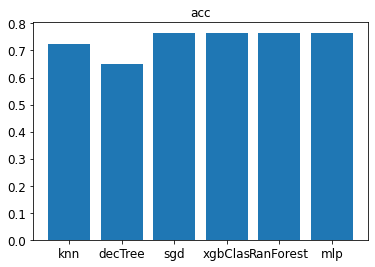

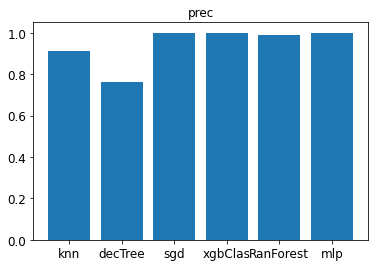

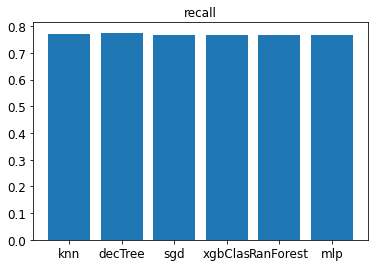

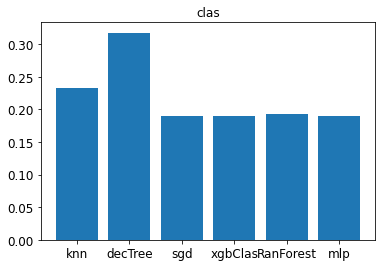

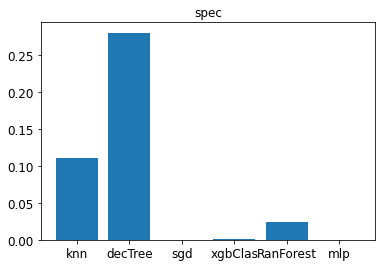

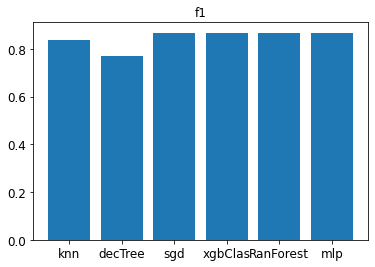

In [116]:
for key, value in metric_model.items():
  plt.bar(value.keys(), value.values())
  plt.title(key)
  plt.show()

Given the model results on testing data, a tree based algorithm is likely the best for high accuracy. Either Random Forest or XGBoost would be the optimal choice.

## Neural Network

### Split Data

In [117]:
# # Prepare Non-PCA data
X_train, X_test, y_train, y_test = train_test_split(features_dl, target_dl, test_size=0.3)

In [118]:
X_train.shape

(1178259, 167)

In [119]:
X_train[0].shape

(167,)

### Build Model

In [120]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=X_train[0].shape))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(7, activation="softmax"))

In [121]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 167)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               21504     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 30,215
Trainable params: 30,215
Non-trainable params: 0
_________________________________________________________________


### Compile Model

In [122]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Train Model

In [123]:
hist = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

Epoch 1/20
29457/29457 [==============================] - 66s 2ms/step - loss: 0.2008 - accuracy: 0.9178 - val_loss: 0.1267 - val_accuracy: 0.9479
Epoch 2/20
29457/29457 [==============================] - 63s 2ms/step - loss: 0.1038 - accuracy: 0.9570 - val_loss: 0.0865 - val_accuracy: 0.9641
Epoch 3/20
29457/29457 [==============================] - 64s 2ms/step - loss: 0.0823 - accuracy: 0.9664 - val_loss: 0.0802 - val_accuracy: 0.9682
Epoch 4/20
29457/29457 [==============================] - 63s 2ms/step - loss: 0.0717 - accuracy: 0.9712 - val_loss: 0.0779 - val_accuracy: 0.9678
Epoch 5/20
29457/29457 [==============================] - 63s 2ms/step - loss: 0.0640 - accuracy: 0.9746 - val_loss: 0.0680 - val_accuracy: 0.9732
Epoch 6/20
29457/29457 [==============================] - 63s 2ms/step - loss: 0.0589 - accuracy: 0.9769 - val_loss: 0.0585 - val_accuracy: 0.9776
Epoch 7/20
29457/29457 [==============================] - 63s 2ms/step - loss: 0.0546 - accuracy: 0.9787 - val_loss: 0

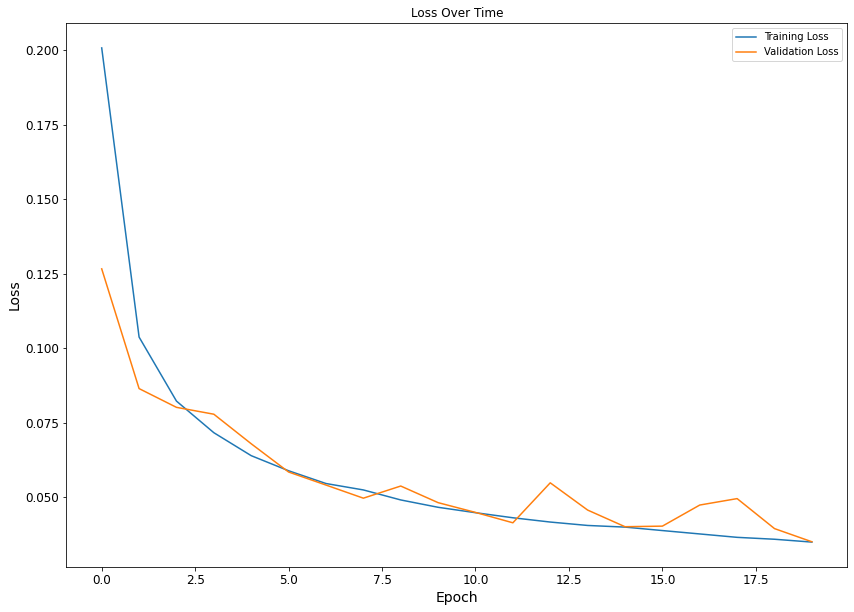

In [124]:
plt.figure(figsize=(14, 10))

epochs_range = range(20)
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()

plt.show()

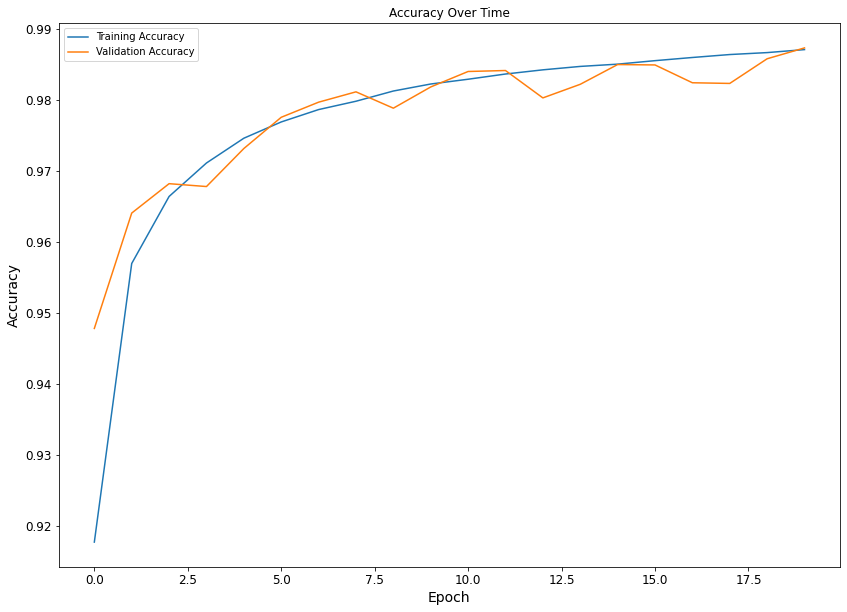

In [128]:
plt.figure(figsize=(14, 10))

epochs_range = range(20)
train_loss = hist.history['accuracy']
val_loss = hist.history['val_accuracy']

plt.plot(epochs_range, train_loss, label="Training Accuracy")
plt.plot(epochs_range, val_loss, label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Time")
plt.legend()

plt.show()

In [125]:
model.evaluate(X_test, y_test)

15781/15781 [==============================] - 24s 2ms/step - loss: 0.0349 - accuracy: 0.9873


[0.03488415852189064, 0.9873279333114624]

In [126]:
model.save('models')

INFO:tensorflow:Assets written to: models/assets


## Results:

Since our Neural Network outperformed our tree based ML algorithms(~98.6% vs ~76.4%), a neural network would be the most effective approach for this dataset. Also, the neural network classified specific graded where the ML methods only classified high vs low grade loans.

## Resources:
https://www.kaggle.com/wordsforthewise/lending-club

https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c

https://scikit-learn.org/stable/index.html

https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390

